In [ ]:
# Bora Güzel
# 2446235

# PART I #

#### Reading the data and importing libraries ####

In [9]:
import pandas as pd #to read the data
import numpy as np 
from sklearn.preprocessing import MinMaxScaler #to normalize the points
scaler= MinMaxScaler() #min max normalization©
import time # to calculate the time elapsed for computing
import matplotlib.pyplot as plt # to plot the necessary graphs


In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl") # I've got error reading the file and found this solution. 
df=pd.read_excel("/Users/boraguzel/Downloads/dermatology.xlsx", header=None)

In [11]:
df.head(5)

0   1   2   3   4   5   6   7   8   9   ...  23  24  25  26  27  28  29  \
0   2   2   0   3   0   0   0   0   1   0  ...   0   0   0   0   3   0   0   
1   3   3   3   2   1   0   0   0   1   1  ...   1   0   0   0   0   0   0   
2   2   1   2   3   1   3   0   3   0   0  ...   0   2   0   2   3   2   0   
3   2   2   2   0   0   0   0   0   3   2  ...   0   0   3   0   0   0   0   
4   2   3   2   2   2   2   0   2   0   0  ...   0   2   2   3   2   3   0   

   30  31  32  
0   0   1   0  
1   0   1   0  
2   0   2   3  
3   0   3   0  
4   0   2   3  

[5 rows x 33 columns]

#### Preprocessing ####

In [12]:
df = scaler.fit_transform(df)
print(df) 


[[0.66666667 0.66666667 0.         ... 0.         0.33333333 0.        ]
 [1.         1.         1.         ... 0.         0.33333333 0.        ]
 [0.66666667 0.33333333 0.66666667 ... 0.         0.66666667 1.        ]
 ...
 [1.         0.66666667 0.66666667 ... 0.         0.66666667 1.        ]
 [0.66666667 0.33333333 1.         ... 0.         0.66666667 1.        ]
 [1.         0.66666667 0.66666667 ... 0.         1.         0.        ]]


### a-) K-means algorithm  ###;

In [17]:
# Number of initializations
num_inits = 500

# I gave a limit to iterations to terminate even if convergence isn't reached
max_iter = 100

# Best SSE (Sum of Squared Errors) initialization
best_sse = float('inf')

# Start timing
start_time = time.time()

# Set random seed for reproducibility
np.random.seed(2446235)

k=10
def k_means_clustering(df, k, num_inits, max_iter=100):
    """
  
    Parameters:
    - df: NumPy array containing the dataset.
    - k: Number of clusters.
    - num_inits: Number of random initializations.
    - max_iter: Maximum number of iterations for convergence.

    Returns:
    - best_labels: Cluster labels for the best initialization.
    - best_centroids: Centroids for the best initialization.
    - best_sse: Sum of squared errors for the best initialization.
    - total_time: Total computing time in seconds.
    - cluster_sizes: Number of data points in each cluster.
    """
    start_time = time.time()  # Start timing

    best_sse = float('inf')  # Initialize best SSE to infinity
    best_labels = None
    best_centroids = None

    for init in range(num_inits):
        # Randomly select initial centroids
        initial_indices = np.random.choice(len(df), k, replace=False)
        centroids = df[initial_indices]
        
        for iteration in range(max_iter):
            # Calculate distances between data points and centroids
            distances = []
            for point in df:
                distance_to_centroids = []
                for centroid in centroids:
                    # Euclidean distance
                    distance = np.sqrt(np.sum((point - centroid) ** 2))
                    distance_to_centroids.append(distance)
                distances.append(distance_to_centroids)
            distances = np.array(distances)
            
            # Assign points to the nearest centroid
            labels = np.argmin(distances, axis=1)
            
            # Recalculate centroids
            new_centroids = []
            for i in range(k):
                points_in_cluster = df[labels == i]
                if len(points_in_cluster) > 0:
                    new_centroid = points_in_cluster.mean(axis=0)
                else:
                    # If a cluster has no points, reinitialize its centroid
                    new_centroid = df[np.random.choice(len(df))]
                new_centroids.append(new_centroid)
            new_centroids = np.array(new_centroids)
            
            # Check for convergence
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids
        
        # Calculate SSE for this initialization
        sse = 0
        for i in range(k):
            points_in_cluster = df[labels == i]
            sse += np.sum((points_in_cluster - centroids[i]) ** 2)
        
        # Update best SSE and labels
        if sse < best_sse:
            best_sse = sse
            best_labels = labels.copy()
            best_centroids = centroids.copy()
            best_iteration = iteration  # Number of iterations taken for the best initialization

    # End timing
    end_time = time.time()
    total_time = end_time - start_time

    # Cluster sizes
    cluster_sizes = np.bincount(best_labels, minlength=k) # minglength=k ensures that even if label(cluster) has 0 count it will be shown

    # Output results


    return best_labels, best_centroids, best_sse, total_time, cluster_sizes, best_iteration
best_labels, best_centroids, best_sse, total_time, cluster_sizes, best_iteration = k_means_clustering(df, k, num_inits, max_iter)

print("==== Final Report ====")
print(f"Converged in {best_iteration+1} iterations during the best initialization.")
print(f"Distance Measure Used: Euclidean Distance")
print(f"Best SSE: {best_sse}")
print(f"Cluster Sizes: {cluster_sizes}")
print(f"Total Computing Time: {total_time:.2f} seconds")

==== Final Report ====
Converged in 9 iterations during the best initialization.
Distance Measure Used: Euclidean Distance
Best SSE: 362.3710254553622
Cluster Sizes: [32 30 31 52 58 40 52 14 37 20]
Total Computing Time: 45.72 seconds


### b-) Bisecting K-means Algorithm and Comparation with part a  ###

In [20]:
np.random.seed(2446235)
def bisecting_kmeans_clustering(df, k, k_means_clustering, init_per_split, max_iter=100):

    import time
    start_time = time.time()  # Start timing

    # Step 1: Initialize with all data in one cluster
    clusters = {0: df}
    cluster_sse = {0: float('inf')}  # Placeholder for initial SSE
    cluster_id = 1  # To assign new cluster IDs

    # Initialize final labels with zeros (all points in one cluster initially)
    final_labels = np.zeros(len(df), dtype=int)
    k_split=2

    while len(clusters) < k:
        # Step 2: Select the cluster to split
        cluster_to_split = max(cluster_sse, key=cluster_sse.get)
        df_to_split = clusters.pop(cluster_to_split)
        current_sse = cluster_sse.pop(cluster_to_split)

        # Step 3: Perform k-means with k=2 on the selected cluster, I used my previous function for k means
        split_labels, split_centroids, split_sse, _, _, _  = k_means_clustering(
            df_to_split, k_split, init_per_split, max_iter
        )

        # Step 4: Split the cluster and update clusters
        for i in range(2):
            points_in_cluster = df_to_split[split_labels == i]
            clusters[cluster_id] = points_in_cluster
            cluster_sse[cluster_id] = np.sum((points_in_cluster - split_centroids[i]) ** 2)
            indices_in_original = np.where(np.isin(df, points_in_cluster, assume_unique=True))[0]
            final_labels[indices_in_original] = cluster_id
            cluster_id += 1

    # Calculate total SSE and cluster sizes
    final_sse = sum(cluster_sse.values())
    cluster_sizes = [len(cluster) for cluster in clusters.values()]

    # Collect centroids
    final_centroids = [cluster.mean(axis=0) for cluster in clusters.values()]

    end_time = time.time()
    total_time = end_time - start_time

    # Output a single final report


    return final_labels, final_centroids, final_sse, total_time, cluster_sizes

k = 10
init_per_split = 50  # Number of initializations for each split
max_iter = 100  # Maximum iterations for k-means

# Correct function definition and testing
final_labels, final_centroids, final_sse, total_time, cluster_sizes = bisecting_kmeans_clustering(
    df, k, k_means_clustering, init_per_split, max_iter
)

print("==== Final Report ====")
print(f"Distance Measure Used: Euclidean Distance")
print(f"Total SSE: {final_sse}")
print(f"Cluster Sizes: {cluster_sizes}")
print(f"Total Computing Time: {total_time:.2f} seconds")
print("=======================")

==== Final Report ====
Distance Measure Used: Euclidean Distance
Total SSE: 362.9355035894373
Cluster Sizes: [52, 32, 20, 28, 67, 45, 34, 38, 16, 34]
Total Computing Time: 2.12 seconds


### c-) Analysis of part a & b for different k values ###

In [21]:
np.random.seed(2446235)
list_times_k_means=[]
list_times_bisecting_k=[]
list_sse_k_means=[]
list_sse_bisecting_k=[]
for k  in range(3,11):
    _, _, sse_k, total_time_k, _, _ = k_means_clustering(df, k, num_inits, max_iter)
    _, _, sse_bisecting, total_time_bisecting, _ = bisecting_kmeans_clustering(
    df, k, k_means_clustering, init_per_split, max_iter        
)
    list_times_k_means.append(total_time_k)
    list_times_bisecting_k.append(total_time_bisecting)
    list_sse_k_means.append(sse_k)
    list_sse_bisecting_k.append(sse_bisecting)
    

#### Results in table ####

In [22]:
from IPython.display import display

# Display the DataFrame in tabular format

results = pd.DataFrame({
    "k": range(3, 11),
    "K-Means Time (s)": list_times_k_means,
    "Bisecting K-Means Time (s)": list_times_bisecting_k,
    "K-Means SSE": list_sse_k_means,
    "Bisecting K-Means SSE": list_sse_bisecting_k
})
display(results)

k  K-Means Time (s)  Bisecting K-Means Time (s)  K-Means SSE  \
0   3          8.244860                    0.751636   542.206028   
1   4         12.666590                    1.137740   478.073136   
2   5         19.236702                    1.339858   441.084736   
3   6         25.230443                    1.565404   417.406958   
4   7         30.587641                    1.954384   400.461196   
5   8         40.318301                    2.029347   384.087207   
6   9         41.091159                    2.090026   372.942604   
7  10         46.174288                    2.164391   362.478463   

   Bisecting K-Means SSE  
0             542.206028  
1             478.369122  
2             454.887168  
3             417.975875  
4             401.419293  
5             384.439364  
6             373.330314  
7             362.950527

#### Results compared in graph ####

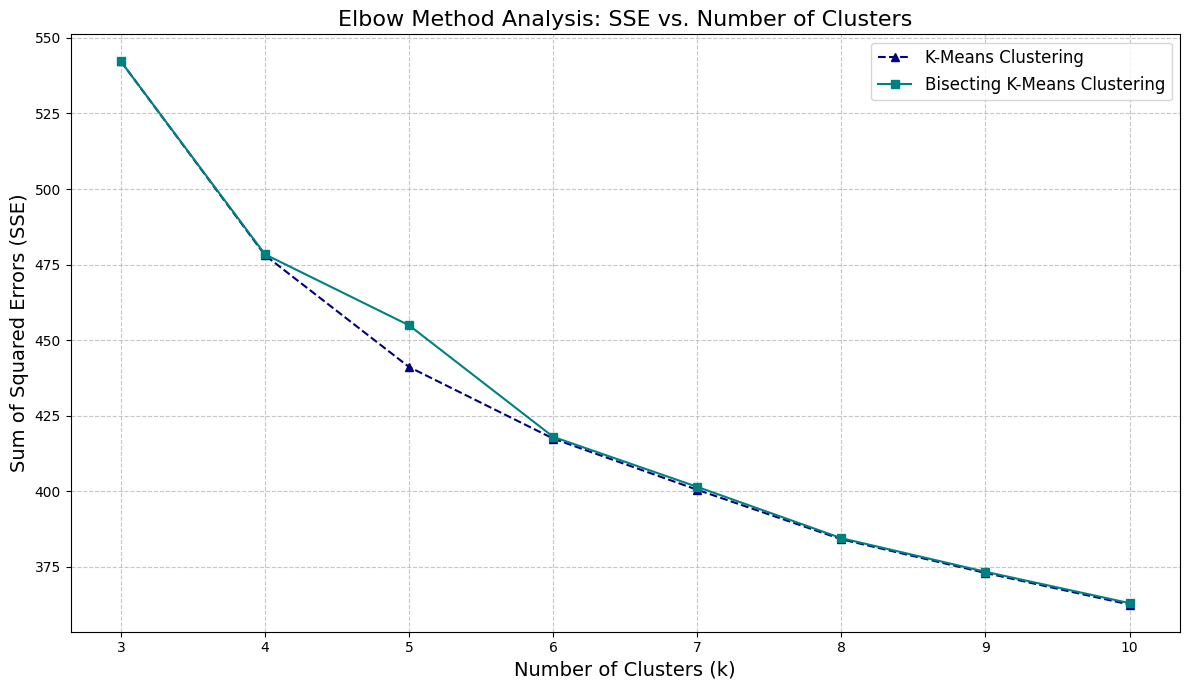

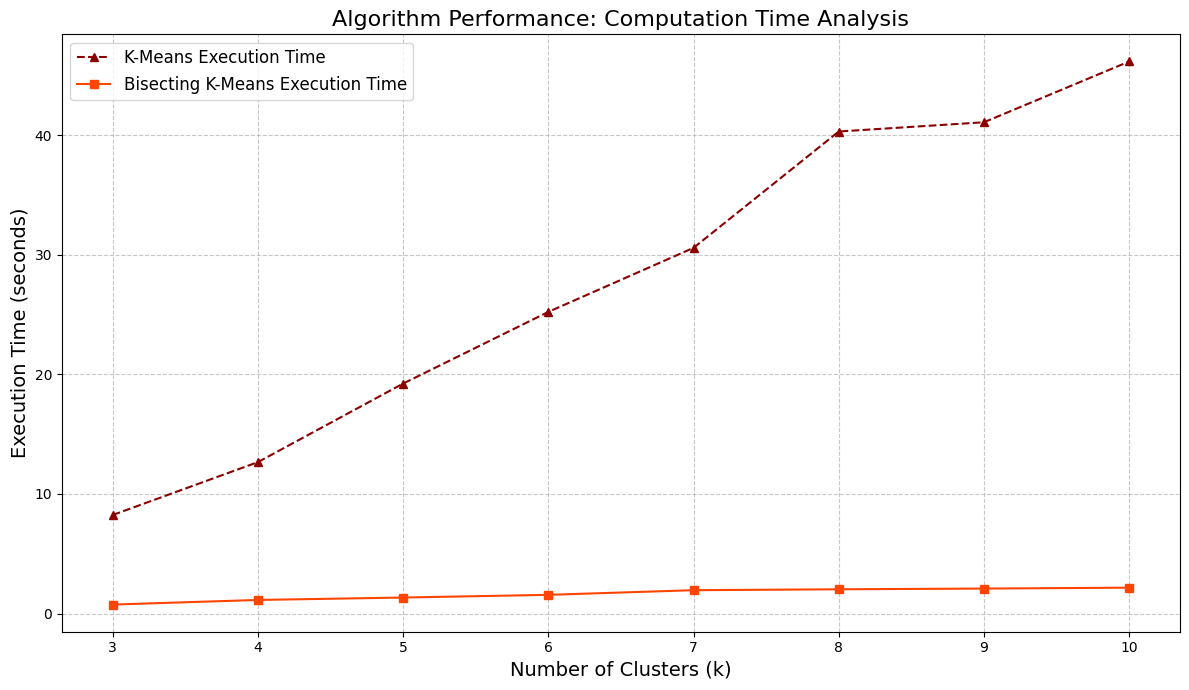

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(range(3, 11), list_sse_k_means, label='K-Means Clustering', marker='^', linestyle='--', color='navy')
plt.plot(range(3, 11), list_sse_bisecting_k, label='Bisecting K-Means Clustering', marker='s', linestyle='-', color='teal')
plt.title('Elbow Method Analysis: SSE vs. Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=14)
plt.xticks(range(3, 11))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 7))
plt.plot(range(3, 11), list_times_k_means, label='K-Means Execution Time', marker='^', linestyle='--', color='darkred')
plt.plot(range(3, 11), list_times_bisecting_k, label='Bisecting K-Means Execution Time', marker='s', linestyle='-', color='orangered')
plt.title('Algorithm Performance: Computation Time Analysis', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)
plt.xticks(range(3, 11))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()